# Analysis of coverage differences in conserved and neutral regions

## Click [here](#Compare-coverages-in-coding-and-non-coding-parts-of-the-Y-chromosome) to skip the setup and code and jump to the results.

Previously we found out that patterns of ancient DNA damage seem to differ in different regions of the genome (autosomes vs Y chromosome, coding vs non-coding regions). We hypothesise that ancient fragments map more poorly in highly diverged regions than in conserved regions, due to an increased number of damage mismatches on top of normal divergence.

We are going to use genome annotation data to get regions of the genome that are protein coding (proxy for conserved) and neutral (pseudogenes etc.) and see if there are differences in coverage between coding and non-coding region.s

GTF/GFF format definitions:

* http://www.ensembl.org/info/website/upload/gff.html
* http://gmod.org/wiki/GFF2

[ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/README]()

Definitions of different features are here: http://www.sequenceontology.org/index.html

For example for [CDS](http://www.sequenceontology.org/browser/current_svn/term/SO:0000316)

In [1]:
import os.path
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from pybedtools import BedTool

In [2]:
plt.style.use('ggplot')

In [3]:
%matplotlib inline

In [4]:
tmp_dir = '../tmp'

### Function definitions

In [5]:
CODING_FEATURES    = ['protein_coding']
NONCODING_FEATURES = [                   
    'pseudogene',
    'processed_pseudogene',
    'transcribed_processed_pseudogene',
    'transcribed_unprocessed_pseudogene',
    'unprocessed_pseudogene'
]


def filter_chromosome(regions, chrom):
    path, filename = os.path.split(regions.fn)
    
    chrom_gtf_file = os.path.join(path, 'chr' + chrom + '_' + filename)
    if os.path.exists(chrom_gtf_file):
        return BedTool(chrom_gtf_file)
    else:
        return regions.filter(lambda f: f.chrom == chrom) \
                      .sort()                             \
                      .saveas(chrom_gtf_file)


def filter_features(regions, feature_type):
    '''Filter given GTF annotations into a specified feature type subset.'''
    path, filename = os.path.split(regions.fn)
    
    if feature_type == 'coding':
        features = CODING_FEATURES 
    elif feature_type == 'noncoding':
        features = NONCODING_FEATURES
    else:
        raise ValueError('feature_type must be either "coding" or "noncoding"')
    
    feature_gtf_file = os.path.join(path, feature_type + '_' + filename)
    if os.path.exists(feature_gtf_file):
        return BedTool(feature_gtf_file)
    else:
        return regions.filter(lambda f: f[1] in features) \
                      .sort()                             \
                      .merge()                            \
                      .saveas(feature_gtf_file)

                    
def coverage_depth(bam_file, regions):
    '''Return a data frame with'''
    bam = BedTool(bam_file)
    return regions.coverage(bam, d=True, sorted=True).to_dataframe()['score']


def coverage_filter(cvg, q=0.975):
    '''Remove positions with coverage higher than q.'''
    return cvg[cvg < cvg.quantile(q)]


def coverage_in_bam(bam_file, coding_regions, noncoding_regions, *,
                    filter_quantile=0.975, subsample=True):
    '''Calculate coverage in a given BAM file in coding and non-coding
    regions of the genome.
    '''
    coding_cvg = coverage_depth(bam_file, coding_regions)
    noncoding_cvg = coverage_depth(bam_file, noncoding_regions)
    
    if filter_quantile:
        coding_cvg = coverage_filter(coding_cvg, filter_quantile)
        noncoding_cvg = coverage_filter(noncoding_cvg, filter_quantile)

    if subsample:
        sample_size = len(coding_cvg) if len(coding_cvg) < len(noncoding_cvg) else len(noncoding_cvg)
        coding_cvg = coding_cvg.sample(sample_size)
        noncoding_cvg = noncoding_cvg.sample(sample_size)

    categories = ['coding', 'non-coding']
    coding_df  = pd.DataFrame({'region': pd.Categorical([categories[0]] * len(coding_cvg), categories), 'cvg': coding_cvg})
    noncoding_df = pd.DataFrame({'region': pd.Categorical([categories[1]] * len(noncoding_cvg), categories), 'cvg': noncoding_cvg})
    
    return pd.concat([coding_df, noncoding_df])


def summarize_coverages(coverages, bam_file, sample=None):
    '''Plot distributions of coverage in coding vs noncoding regions.'''
    
    print('Summary of coverages in coding/non-coding regions in ', bam_file)
    print('=============================================')
    
    if sample:
        coverages = coverages.groupby('region').apply(pd.DataFrame.sample, sample)
        
    groups = coverages.groupby('region')
    
    coding_cvg = groups.get_group('coding')['cvg']
    noncoding_cvg = groups.get_group('non-coding')['cvg']
    
    print(groups.describe(percentiles=[0.5]))
    
    print()
    
    print('Proportion of sites with zero coverage:')
    print('\tin coding regions:\t', (coding_cvg == 0).mean())
    print('\tin non-coding regions:\t', (noncoding_cvg == 0).mean())
    
    print()
    
    s1, p1 = stats.mannwhitneyu(coding_cvg, noncoding_cvg, alternative='greater')
    s2, p2 = stats.mannwhitneyu(coding_cvg[coding_cvg > 0], noncoding_cvg[noncoding_cvg > 0], alternative='greater')
                                
    print('Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)')
    print('\tincluding sites with no coverage: p-value = ', p1)
    print('\tonly sites with coverage: p-value = ', p2)

    plt.figure(figsize=(12, 6))
    plt.xlim(0, coverages.cvg.max())
    plt.xlabel('coverage')
    plt.ylabel('density')
    plt.title(os.path.basename(bam_file))

    sns.kdeplot(groups.get_group('coding')['cvg'], bw=1)
    sns.kdeplot(groups.get_group('non-coding')['cvg'], bw=1)

    plt.legend(['coding', 'non-coding'])

### Download genome annotations

In [6]:
gtf_file = os.path.join(tmp_dir, 'Homo_sapiens.GRCh37.75.gtf.gz')

In [7]:
!curl ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz > $gtf_file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 37.5M  100 37.5M    0     0  3015k      0  0:00:12  0:00:12 --:--:-- 3059k


### Load coordinates of protein coding regions and pseudogenes on the Y chromosome

In [8]:
map_filter = BedTool('/mnt/454/HCNDCAM/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz')

In [9]:
genome_gtf_file = os.path.join(tmp_dir, 'map99_Homo_sapiens.GRCh37.75.gtf.gz')

if os.path.exists(genome_gtf_file):
    genome_gtf = BedTool(genome_gtf_file)
else:
    genome_gtf = BedTool(gtf_file)         \
                    .intersect(map_filter) \
                    .saveas(genome_gtf_file)

In [10]:
y_gtf = filter_chromosome(genome_gtf, 'Y')

In [11]:
y_coding = filter_features(y_gtf, 'coding')
y_noncoding = filter_features(y_gtf, 'noncoding')

### What is the size of coding and pseudogene regions?

In [12]:
print('Coding regions: \t{} bp'.format(y_coding.total_coverage()))
print('Non-coding regions:\t{} bp'.format(y_noncoding.total_coverage()))

Coding regions: 	680686 bp
Non-coding regions:	459548 bp


<br><br><br>
# Compare coverages in coding and non-coding parts of the Y chromosome

## A00 individual #1

In [15]:
a00_1_coverages = coverage_in_bam('../tmp/GRC13292545.chrY.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../tmp/GRC13292545.chrY.bam
                            cvg
region                         
coding     count  442339.000000
           mean        8.625678
           std         3.341469
           min         0.000000
           50%         9.000000
           max        16.000000
non-coding count  442339.000000
           mean        8.654640
           std         3.380585
           min         0.000000
           50%         9.000000
           max        16.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00453950476897
	in non-coding regions:	 0.0035402711495

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.996385250903
	only sites with coverage: p-value =  0.970187117755


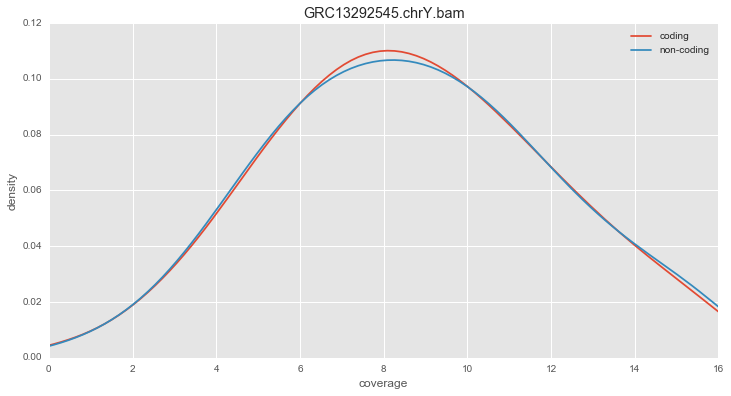

In [16]:
summarize_coverages(a00_1_coverages, '../tmp/GRC13292545.chrY.bam')

## A00 individual #2

In [17]:
a00_2_coverages = coverage_in_bam('../tmp/GRC13292546.chrY.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../tmp/GRC13292546.chrY.bam
                            cvg
region                         
coding     count  445657.000000
           mean       11.898920
           std         4.003350
           min         0.000000
           50%        12.000000
           max        21.000000
non-coding count  445657.000000
           mean       11.928117
           std         4.023399
           min         0.000000
           50%        12.000000
           max        21.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00272406806131
	in non-coding regions:	 0.00199031990971

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.999999573872
	only sites with coverage: p-value =  0.99999282433


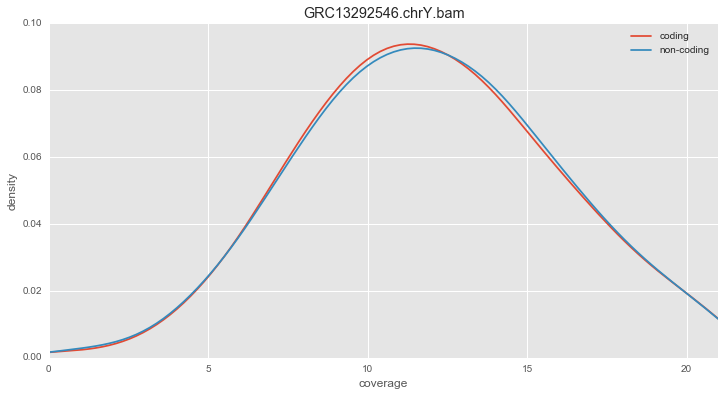

In [18]:
summarize_coverages(a00_2_coverages, '../tmp/GRC13292546.chrY.bam')

## Anonymous donor &mdash; normal

In [19]:
anon_default = coverage_in_bam('/mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  /mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam
                            cvg
region                         
coding     count  447310.000000
           mean        9.058443
           std         3.262896
           min         0.000000
           50%         9.000000
           max        16.000000
non-coding count  447310.000000
           mean        9.094988
           std         3.250587
           min         0.000000
           50%         9.000000
           max        16.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00383179450493
	in non-coding regions:	 0.00372001520199

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.999999998612
	only sites with coverage: p-value =  0.999999998023


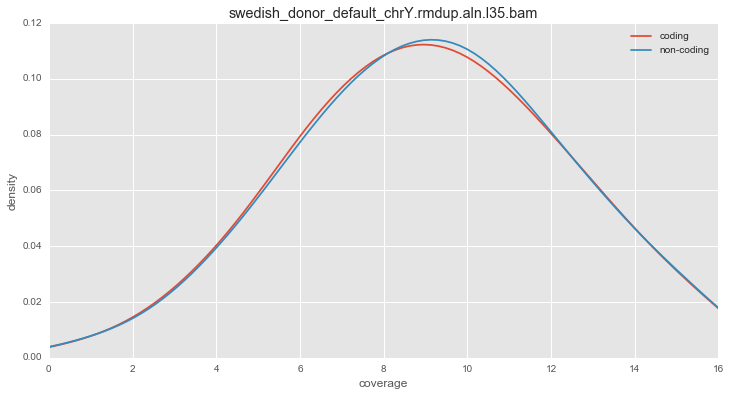

In [20]:
summarize_coverages(anon_default, '/mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam')

## Anonymous donor &mdash; ancient

In [21]:
anon_ancient = coverage_in_bam('/mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  /mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam
                            cvg
region                         
coding     count  440881.000000
           mean       10.756578
           std         3.052703
           min         0.000000
           50%        11.000000
           max        17.000000
non-coding count  440881.000000
           mean       10.831673
           std         3.069646
           min         0.000000
           50%        11.000000
           max        17.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.000147432073507
	in non-coding regions:	 0.000244964060597

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  1.0
	only sites with coverage: p-value =  1.0


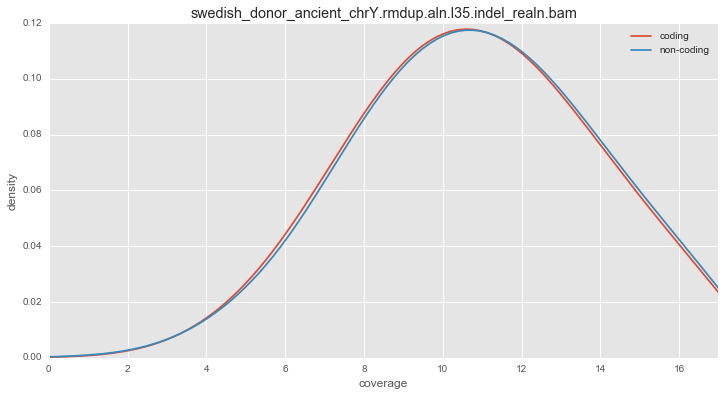

In [22]:
summarize_coverages(anon_ancient, '/mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam')

## Ust-Ishim

In [13]:
ui_coverages = coverage_in_bam('../../y-selection/bam/y_ustishim.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_ustishim.bam
                            cvg
region                         
coding     count  447016.000000
           mean       21.146022
           std         6.485288
           min         0.000000
           50%        22.000000
           max        34.000000
non-coding count  447016.000000
           mean       19.110558
           std         7.527561
           min         0.000000
           50%        20.000000
           max        33.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0172499418365
	in non-coding regions:	 0.051089893874

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.0
	only sites with coverage: p-value =  0.0


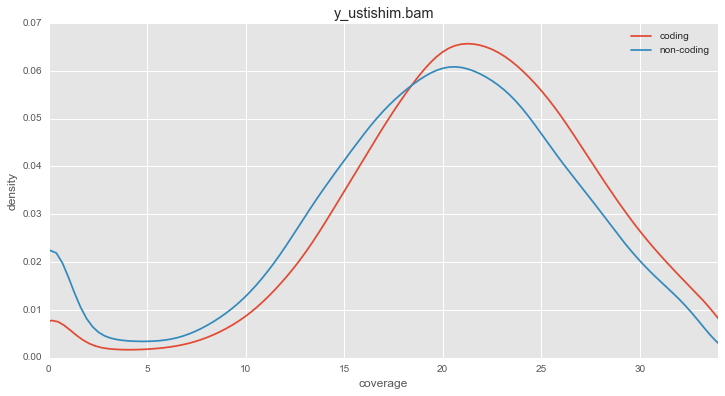

In [14]:
summarize_coverages(ui_coverages, '../../y-selection/bam/y_ustishim.bam')

## Mota

In [43]:
mota_coverages = coverage_in_bam('../../y-selection/bam/y_mota.bam', y_coding, y_noncoding)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_mota.bam
                            cvg
region                         
coding     count  446131.000000
           mean        6.405399
           std         2.721871
           min         0.000000
           50%         6.000000
           max        12.000000
non-coding count  446131.000000
           mean        5.874499
           std         2.940386
           min         0.000000
           50%         6.000000
           max        12.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0232913650923
	in non-coding regions:	 0.0632639292047

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.0
	only sites with coverage: p-value =  0.0


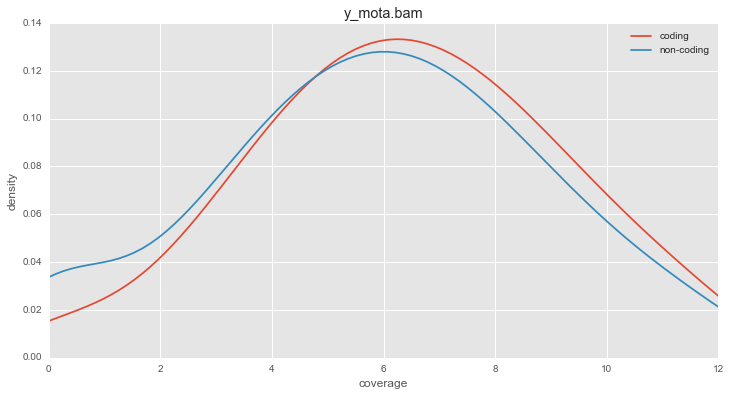

In [44]:
summarize_coverages(mota_coverages, '../../y-selection/bam/y_mota.bam')

<br><br><br>
# Coverage in Basti's regions and in a subset of these that overlap exome

Basti's regions are ~570 kb, of which 18 kb overlap exome regions from Castellano et al. Here I took the 18 kb of this overlap as "coding" regions and a random 18 kb subset of the remaining 570 kb as "non-coding" regions.

This might be too little data, but there is a strong difference in El Sidron coverages, as we would predict from our analysis of different damage patterns (ancient reads mapping more poorly to non-coding regions than coding regions, leading to weaker damage pattern signal and lower coverage too).

In [23]:
lippold_bed = BedTool('../input/lippold_regions.bed')
exome_bed = BedTool('../input/exome_regions.bed')

In [24]:
coding_bed = lippold_bed.intersect(exome_bed)
noncoding_bed = lippold_bed.subtract(exome_bed)

## El Sidron

In [25]:
sidron_cvg = coverage_in_bam('../bam/lippold_sidron.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../bam/lippold_sidron.bam
                           cvg
region                        
coding     count  18446.000000
           mean      10.181069
           std        4.939653
           min        0.000000
           50%       10.000000
           max       22.000000
non-coding count  18446.000000
           mean       7.986610
           std        4.817784
           min        0.000000
           50%        8.000000
           max       20.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00840290577903
	in non-coding regions:	 0.0424482272579

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.0
	only sites with coverage: p-value =  4.94096352609e-298


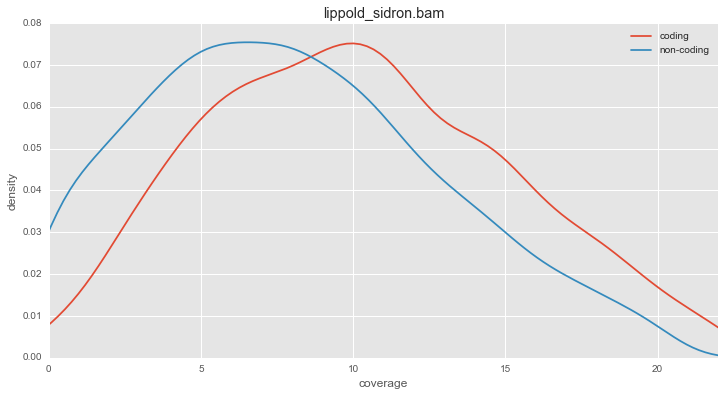

In [26]:
summarize_coverages(sidron_cvg, '../bam/lippold_sidron.bam')

## A00 individual #1

In [27]:
a00_1_cvg = coverage_in_bam('../tmp/GRC13292545.chrY.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../tmp/GRC13292545.chrY.bam
                           cvg
region                        
coding     count  18296.000000
           mean       9.290719
           std        3.493379
           min        0.000000
           50%        9.000000
           max       17.000000
non-coding count  18296.000000
           mean       8.850295
           std        3.394536
           min        0.000000
           50%        9.000000
           max       17.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0004372540446
	in non-coding regions:	 0.00120244862265

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  5.58641260062e-32
	only sites with coverage: p-value =  2.09274314439e-31


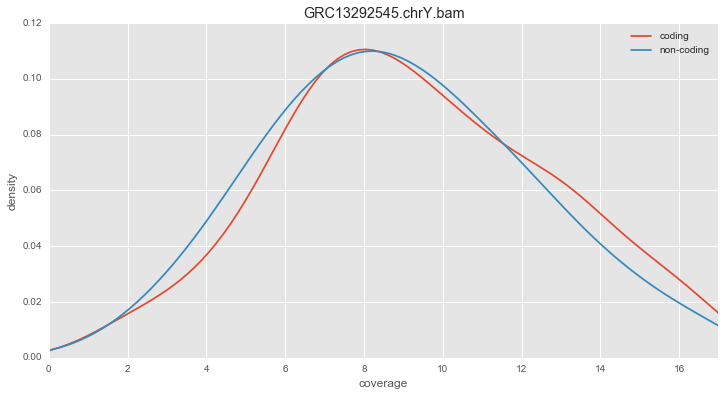

In [28]:
summarize_coverages(a00_1_cvg, '../tmp/GRC13292545.chrY.bam')

## A00 individual #2

In [29]:
a00_2_cvg = coverage_in_bam('../tmp/GRC13292546.chrY.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../tmp/GRC13292546.chrY.bam
                           cvg
region                        
coding     count  18280.000000
           mean      12.495569
           std        4.070537
           min        2.000000
           50%       12.000000
           max       21.000000
non-coding count  18280.000000
           mean      12.230252
           std        3.935943
           min        1.000000
           50%       12.000000
           max       21.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  1.41549885754e-10
	only sites with coverage: p-value =  1.41549885754e-10


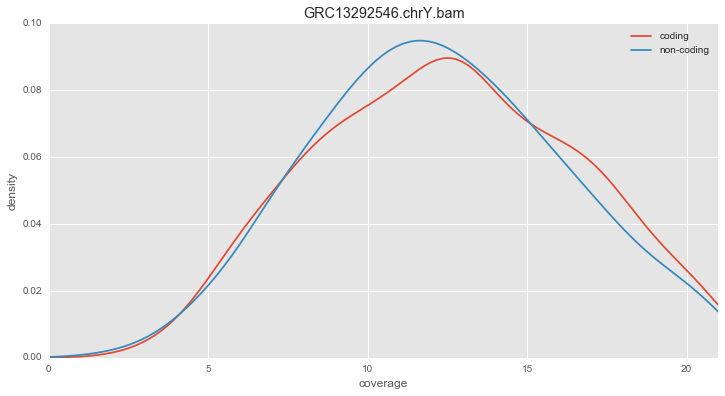

In [30]:
summarize_coverages(a00_2_cvg, '../tmp/GRC13292546.chrY.bam')

## Anonymous donor &mdash; normal

In [31]:
anon_default_cvg = coverage_in_bam('/mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  /mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam
                           cvg
region                        
coding     count  18369.000000
           mean       9.422886
           std        3.124373
           min        1.000000
           50%        9.000000
           max       16.000000
non-coding count  18369.000000
           mean       9.523817
           std        3.047245
           min        0.000000
           50%       10.000000
           max       16.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.000217758179542

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.993236262424
	only sites with coverage: p-value =  0.993896941161


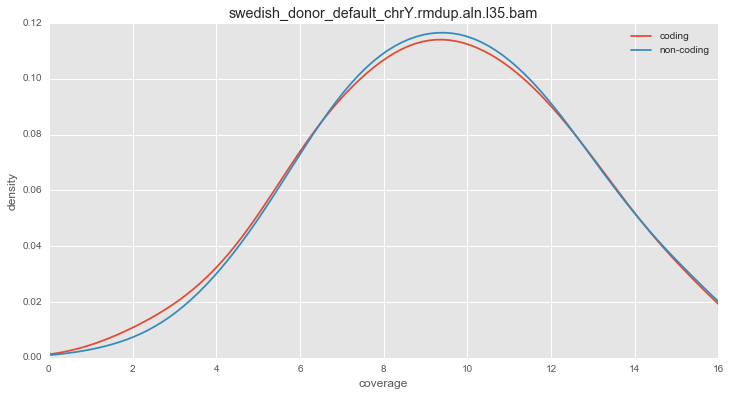

In [32]:
summarize_coverages(anon_default_cvg, '/mnt/454/AncientDNA_Control/0_bam/swedish_donor_default_chrY.rmdup.aln.l35.bam')

## Anonymous donor &mdash; ancient

In [33]:
anon_ancient_cvg = coverage_in_bam('/mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  /mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam
                           cvg
region                        
coding     count  18401.000000
           mean      11.232161
           std        3.272748
           min        1.000000
           50%       11.000000
           max       18.000000
non-coding count  18401.000000
           mean      11.130645
           std        3.151414
           min        1.000000
           50%       11.000000
           max       18.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.0
	in non-coding regions:	 0.0

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  0.00614072173734
	only sites with coverage: p-value =  0.00614072173734


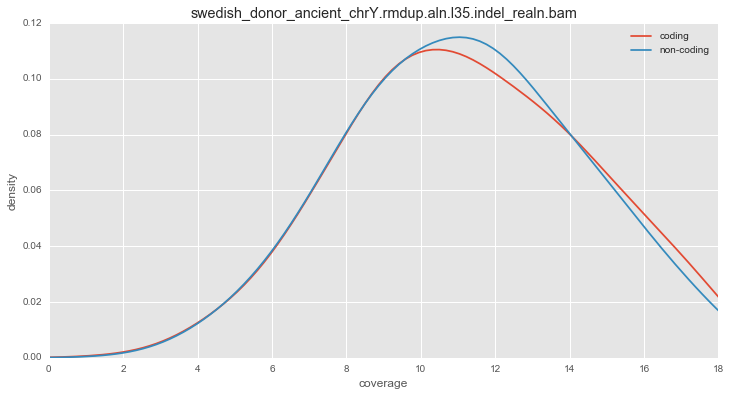

In [34]:
summarize_coverages(anon_ancient_cvg, '/mnt/454/AncientDNA_Control/0_bam/swedish_donor_ancient_chrY.rmdup.aln.l35.indel_realn.bam')

## Ust-Ishim

In [35]:
ui_cvg = coverage_in_bam('../../y-selection/bam/y_ustishim.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_ustishim.bam
                           cvg
region                        
coding     count  18429.000000
           mean      19.908134
           std        5.466433
           min        0.000000
           50%       20.000000
           max       32.000000
non-coding count  18429.000000
           mean      20.379185
           std        5.870816
           min        0.000000
           50%       20.000000
           max       33.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.000596885343752
	in non-coding regions:	 0.00645721417331

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  1.0
	only sites with coverage: p-value =  1.0


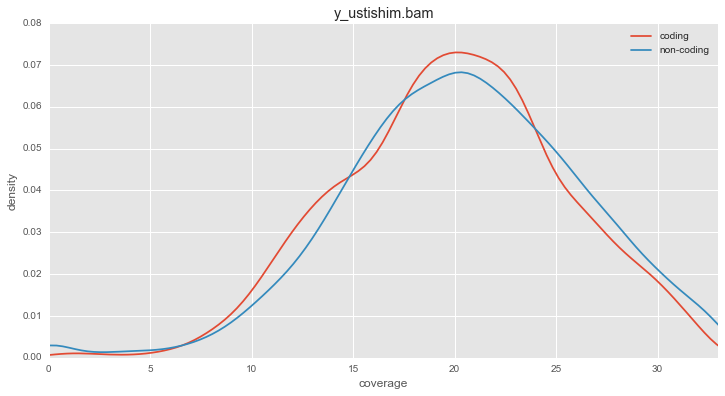

In [49]:
summarize_coverages(ui_cvg, '../../y-selection/bam/y_ustishim.bam')

## Mota

In [37]:
mota_cvg = coverage_in_bam('../../y-selection/bam/y_mota.bam', coding_bed, noncoding_bed)

Summary of coverages in coding/non-coding regions in  ../../y-selection/bam/y_mota.bam
                           cvg
region                        
coding     count  18262.000000
           mean       6.472511
           std        2.663540
           min        0.000000
           50%        6.000000
           max       12.000000
non-coding count  18262.000000
           mean       6.328880
           std        2.627305
           min        0.000000
           50%        6.000000
           max       12.000000

Proportion of sites with zero coverage:
	in coding regions:	 0.00662578030884
	in non-coding regions:	 0.00958274011609

Hypothesis: do coding regions have higher coverage than non-coding? (Mann-Whitney U test)
	including sites with no coverage: p-value =  2.62749658648e-07
	only sites with coverage: p-value =  2.29211932858e-06


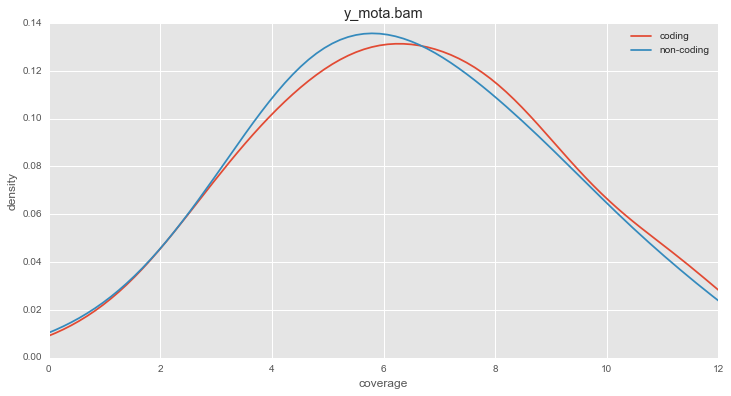

In [38]:
summarize_coverages(mota_cvg, '../../y-selection/bam/y_mota.bam')